# Testing EDI Vetter Unplugged tool for WASP 18b
## (~0.92 day Period, ~13 Earth Radii Radius)

In [39]:
import EDIunplugged as EDI
import lightkurve as lk
from wotan import flatten

import os,sys
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
pd.set_option('display.notebook_repr_html', True)

import lightkurve as lk
lk.log.setLevel('INFO')

#pipeline settings
path=os.getcwd()+'/'

/Users/Dax/opt/anaconda3/lib/python3.8/site-packages/lightkurve/lightcurvefile.py:45: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  warnings.warn("`LightCurveFile.header` is deprecated, please use "
7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


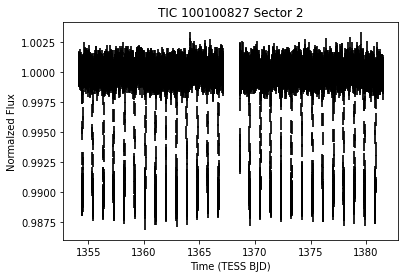

In [40]:
ID=100100827; Sector=2


#save to local directory
downloadpath=os.getcwd()+'/'

target='TIC '+str(ID)
lc_2min=lk.search.search_lightcurvefile(target, cadence='short', mission=("TESS"),sector=Sector).download(download_dir=downloadpath)
lc_2min_precut=lc_2min.PDCSAP_FLUX.remove_nans().normalize()

#apply quality mask
q = lc_2min_precut.quality!=0
lc_2min = lk.LightCurve(time=lc_2min_precut.time[~q],flux=lc_2min_precut.flux[~q],flux_err=lc_2min_precut.flux_err[~q])


plt.errorbar(x=lc_2min_precut.time,y=lc_2min_precut.flux,yerr=lc_2min_precut.flux_err,color='grey',linestyle='none')
plt.errorbar(x=lc_2min.time,y=lc_2min.flux,yerr=lc_2min.flux_err,color='black',linestyle='none')
plt.xlabel('Time (TESS BJD)')
plt.ylabel('Normalzed Flux')
plt.title('TIC '+str(ID)+' Sector '+str(Sector))
plt.show()

In [41]:
#saving in current working directory
input_LC = pd.DataFrame({'Time':lc_2min.time, 'SAP Flux':lc_2min.flux, 'SAP Error':lc_2min.flux_err})
input_LC.to_csv(os.getcwd()+'/TIC_'+str(ID)+'_Sector_'+str(Sector)+'_SPOC_LC.csv')


Transit Least Squares TLS 1.0.25 (04 June 2020)
Creating model cache for 35 durations
Searching 18316 data points, 1479 periods from 0.858 to 9.135 days
Using all 4 CPU threads


/Users/Dax/opt/anaconda3/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lc_arr = numpy.array(lc_arr)


 
TIC 100100827 Sector 2
Period: 0.9414328975931052
Odd/Even Mismatch:  0.11401218364993225
Transit Count:  29


<ipython-input-63-c1c0927b2999>:87: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



 ___________ _____      _   _      _   _            
|  ___|  _  \_   _|    | | | |    | | | |           
| |__ | | | | | |______| | | | ___| |_| |_ ___ _ __ 
|  __|| | | | | |______| | | |/ _ \ __| __/ _ \ '__|
| |___| |/ / _| |_     \ \_/ /  __/ |_| ||  __/ |   
\____/|___/  \___/      \___/ \___|\__|\__\___|_|   Unplugged
    
Version 0.1.2 (11 Sept 2020)
            Vetting Report
        Flux Contamination : False
  Too Many Transits Masked : False
Odd/Even Transit Variation : False
      Signal is not Unique : False
   Secondary Eclipse Found : False
Low Transit Phase Coverage : False
 Transit Duration Too Long : False
Signal is a False Positive : False


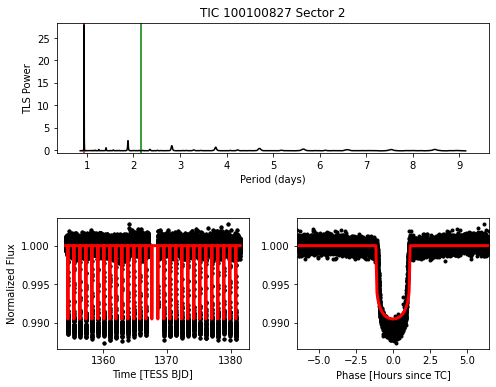

In [63]:
known_period = 0.94124 #WASP 18b
known_period2 = 2.1558 #WASP 18c

time=input_LC['Time']
flux=input_LC['SAP Flux']
error=input_LC['SAP Error']

from transitleastsquares import transitleastsquares

#input parameters
N_transits=3
minP=0.5
oversampling_factor=3
duration_grid_step=1.1
T0_fit_margin = 0.001
maxP= (max(time)-min(time))/N_transits #length of our light curve

#for reporting TLS model's planet radius
R_earth = 6.378*10.0**8.0 #cm
R_sun = 6.955*10.0**10.0 #cm

#getting stellar parameters from TIC
from transitleastsquares import catalog_info    
qld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)

def phasefold(T0,time,period,flux):
    phase=(time- T0 + 0.5*period) % period - 0.5*period        
    ind=np.argsort(phase, axis=0)
    return phase[ind],flux[ind]

tls = transitleastsquares(time,flux,error)

tls_power = tls.power(R_star_min=R_star-R_star_min, R_star_max=R_star+R_star_max,R_star=R_star,\
                                  M_star_min=M_star-M_star_min, M_star_max=M_star+M_star_max,M_star=M_star,\
                                  u=qld,period_min=minP,period_max=maxP,\
                                  n_transits_min=N_transits,\
                                  oversampling_factor=oversampling_factor,\
                                  duration_grid_step=duration_grid_step,\
                                  T0_fit_margin=T0_fit_margin,show_progress_bar=False)
print(' ')
print('TIC '+str(ID)+' Sector '+str(Sector))
print('Period: '+str(tls_power.period))
print('Odd/Even Mismatch: ',tls_power.odd_even_mismatch)
print('Transit Count: ',tls_power.transit_count)

ModelT=tls_power.model_lightcurve_time 
ModelF=tls_power.model_lightcurve_model



#phase folding LC and TLS model
pf,ff  = phasefold(tls_power.T0, time, tls_power.period,flux)
pf_model,ff_model = phasefold(ModelT,tls_power.T0,tls_power.period,ModelF)

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)
###
###
fig = plt.figure(figsize=(10,6))        
ax1 = fig.add_subplot(gs1[0:1, 0:2])
ax2 = fig.add_subplot(gs1[1:, 0:1])
ax3 = fig.add_subplot(gs1[1:, 1:2])


ax1.plot(tls_power.periods, tls_power.power, color='black',rasterized=True)
ax1.axvline(x=known_period,color='red',zorder=-1)
ax1.axvline(x=known_period2,color='green',zorder=-1)
ax1.set_title("TIC "+str(ID)+" "+"Sector "+str(Sector))#" Camera "+Camera+" CCD "+CCD)
ax1.set_xlabel("Period (days)")
ax1.set_xticks(np.arange(0.0, 15.0, 1.0))
ax1.set_xlim(np.min(tls_power.periods)-0.5, np.max(tls_power.periods)+0.5)
###
ax1.set_ylabel("TLS Power")
ax1.set_ylim(np.min(tls_power.power)-0.5, np.max(tls_power.power)+0.5)

ax2.plot(time,flux,'k.')
ax2.set_ylabel('Normalized Flux')
ax2.set_xlabel('Time [TESS BJD]')
ax2.plot(time,flux,'k.')
ax2.plot(ModelT,ModelF,'r-',linewidth=3)

ax3.plot(24*pf,ff,'k.')
ax3.plot(24*pf_model,ff_model,'r-',linewidth=3)
ax3.set_xlim(-3*24*tls_power.duration,3*24*tls_power.duration)
ax3.set_xlabel('Phase [Hours since TC]')
fig.savefig('TIC_'+str(ID)+'_Sector_'+str(Sector)+'_SPOC_TLS_result.png',bbox_inches='tight')
fig.show()

params=EDI.parameters(tls_power,limbDark=[qld[0], qld[1]], impact=0, snrThreshold=6, minTransit=N_transits)
params=EDI.Go(params,telescope='TESS')

In [64]:
params=EDI.Go(params,telescope='TESS')


 ___________ _____      _   _      _   _            
|  ___|  _  \_   _|    | | | |    | | | |           
| |__ | | | | | |______| | | | ___| |_| |_ ___ _ __ 
|  __|| | | | | |______| | | |/ _ \ __| __/ _ \ '__|
| |___| |/ / _| |_     \ \_/ /  __/ |_| ||  __/ |   
\____/|___/  \___/      \___/ \___|\__|\__\___|_|   Unplugged
    
Version 0.1.2 (11 Sept 2020)
            Vetting Report
        Flux Contamination : False
  Too Many Transits Masked : False
Odd/Even Transit Variation : False
      Signal is not Unique : False
   Secondary Eclipse Found : False
Low Transit Phase Coverage : False
 Transit Duration Too Long : False
Signal is a False Positive : False


In [65]:
EDI_results = pd.DataFrame({'ID':ID,'Flux Contamination':params.fluxContaminationFP, 'Too Many Transits Masked':params.TransMaskFP, 'Odd/Even Transit Variation':params.even_odd_transit_misfit,'Signal is not Unique':params.uniquenessFP,'Secondary Eclipse Found':params.SeFP,'Low Transit Phase Coverage':params.phaseCoverFP, 'Transit Duration Too Long':params.tdurFP, 'Signal is a False Positive':params.FalsePositive},index=[0])
EDI_results.to_csv('TIC_'+str(ID)+'_Sector_'+str(Sector)+'_EDI-Vetter_results.csv')


In [66]:
EDI_results

,ID,Flux Contamination,Too Many Transits Masked,Odd/Even Transit Variation,Signal is not Unique,Secondary Eclipse Found,Low Transit Phase Coverage,Transit Duration Too Long,Signal is a False Positive
0,100100827,False,False,False,False,False,False,False,False
